# Import Libraries

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os

os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random

random.seed(SEED)

import numpy as np

np.random.seed(SEED)

import tensorflow as tf

tf.random.set_seed(SEED)

import math
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup

# Read Data

In [3]:
import pandas as pd

df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104089,8,2021,710 YISHUN AVENUE 5,Yishun,0.826153,14.410089,0.016807,0.000382,"4 ROOM, New Generation",61.750000,93.0,07 TO 09,390000.0
104090,8,2021,117 YISHUN RING ROAD,Yishun,1.045337,15.215236,0.016807,0.000382,"4 ROOM, Model A",60.916667,104.0,07 TO 09,380000.0
104091,8,2021,453 YISHUN STREET 41,Khatib,1.424543,13.350952,0.016807,0.000968,"4 ROOM, Model A",91.083333,93.0,04 TO 06,433000.0
104092,8,2021,505D YISHUN STREET 51,Khatib,1.259536,13.232993,0.016807,0.000968,"4 ROOM, Model A",93.666667,93.0,01 TO 03,460000.0


In [4]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop('resale_price')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(
        output_mode='binary')  # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

## Question 1

Real world datasets often contain a mix of numeric and categorical features – this dataset is one such example. Modelling such a mix of feature types with neural networks requires some modifications to the input layer. This tutorial from the Keras documentation guides you through the process of using the Functional API to do so.

In [5]:
class Question1():

    def __init__(self, train_ds, val_ds, epochs=100):
        self.epochs = epochs
        self.seed = 42
        self.filepath = 'p2q1f.ckpt'
        self.history = None

        self.train_ds = train_ds
        self.val_ds = val_ds

        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)

    def prepare_model(self):
        # categorical feature encoded as integer
        month = keras.Input(shape=(1,), name='month', dtype='int64')

        # categorical features encoded as strings
        storey_range = keras.Input(shape=(1,), name='storey_range', dtype='string')
        flat_model_type = keras.Input(shape=(1,), name='flat_model_type', dtype='string')

        # numerical features
        floor_area_sqm = keras.Input(shape=(1,), name='floor_area_sqm')
        remaining_lease_years = keras.Input(shape=(1,), name='remaining_lease_years')
        degree_centrality = keras.Input(shape=(1,), name='degree_centrality')
        eigenvector_centrality = keras.Input(shape=(1,), name='eigenvector_centrality')
        dist_to_nearest_stn = keras.Input(shape=(1,), name='dist_to_nearest_stn')
        dist_to_dhoby = keras.Input(shape=(1,), name='dist_to_dhoby')

        self.all_inputs = [month,
                           storey_range,
                           flat_model_type,
                           floor_area_sqm,
                           remaining_lease_years,
                           degree_centrality,
                           eigenvector_centrality,
                           dist_to_nearest_stn,
                           dist_to_dhoby]

        # integer categorical features
        month_encoded = encode_categorical_feature(month, 'month', self.train_ds, False)

        # string categorical features
        storey_range_encoded = encode_categorical_feature(storey_range, 'storey_range', self.train_ds, True)
        flat_model_type_encoded = encode_categorical_feature(flat_model_type, 'flat_model_type', self.train_ds, True)

        # numerical features
        floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, 'floor_area_sqm', self.train_ds)
        remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, 'remaining_lease_years',
                                                                 self.train_ds)
        degree_centrality_encoded = encode_numerical_feature(degree_centrality, 'degree_centrality', self.train_ds)
        eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, 'eigenvector_centrality',
                                                                  self.train_ds)
        dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, 'dist_to_nearest_stn',
                                                               self.train_ds)
        dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, 'dist_to_dhoby', self.train_ds)

        self.all_features = tf.keras.layers.concatenate([month_encoded,
                                                         storey_range_encoded,
                                                         flat_model_type_encoded,
                                                         floor_area_sqm_encoded,
                                                         remaining_lease_years_encoded,
                                                         degree_centrality_encoded,
                                                         eigenvector_centrality_encoded,
                                                         dist_to_nearest_stn_encoded,
                                                         dist_to_dhoby_encoded])

    @staticmethod
    def r_square(y_true, y_pred):
        SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
        SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
        return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

    def create_model(self):
        # create the model
        x = tf.keras.layers.Dense(units=10, activation='relu')(self.all_features)
        output = tf.keras.layers.Dense(units=1, activation='linear')(x)
        self.model = tf.keras.Model(inputs=self.all_inputs, outputs=output)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
                           loss=tf.keras.losses.MeanSquaredError(),
                           metrics=[self.r_square])

    def summarize_model(self):
        # summarize the model
        print(self.model.summary())

    def train_model(self):
        # train the model
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self.filepath,
                                                                       monitor='val_loss',
                                                                       verbose=1,
                                                                       save_best_only=True,
                                                                       save_weights_only=True,
                                                                       mode='min')
        self.history = self.model.fit(x=train_ds,
                                      batch_size=128,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[model_checkpoint_callback],
                                      validation_data=self.val_ds)

    def plot_model(self, variable='loss', epoch_start=1, epoch_end=None):
        # plot learning curves
        train_epochs = self.history.history[variable][epoch_start - 1:epoch_end]
        val_epochs = self.history.history['val_{}'.format(variable)][epoch_start - 1:epoch_end]
        number_epochs = len(self.history.history[variable][epoch_start - 1:epoch_end])

        plt.plot(range(epoch_start, epoch_start + number_epochs), train_epochs,
                 label='Model training {}'.format(variable))
        plt.plot(range(epoch_start, epoch_start + number_epochs), val_epochs, label='Model testing {}'.format(variable))
        plt.title('Model {}'.format(variable))
        plt.ylabel('{}'.format(variable))
        plt.xlabel('epoch')
        plt.legend(loc='best')
        plt.show()

    def plot_rmse_model(self, epoch_start=1, epoch_end=None):
        # plot rmse curves
        train_epochs = list(map(lambda x: math.sqrt(x), self.history.history['loss'][epoch_start - 1:epoch_end]))
        val_epochs = list(map(lambda x: math.sqrt(x), self.history.history['val_loss'][epoch_start - 1:epoch_end]))
        number_epochs = len(self.history.history['loss'][epoch_start - 1:epoch_end])

        plt.plot(range(epoch_start, epoch_start + number_epochs), train_epochs, label='Model training rmse')
        plt.plot(range(epoch_start, epoch_start + number_epochs), val_epochs, label='Model testing rmse')
        plt.title('Model rmse')
        plt.ylabel('rmse')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        plt.show()

    def get_lowest_test_error_model(self):
        # get lowest test error epoch and R2 value
        lowest_test_error, lowest_test_error_epoch = min(
            (value, index + 1) for (index, value) in enumerate(self.history.history['val_loss']))
        print('Lowest test error: {}'.format(lowest_test_error))
        print('Lowest test error epoch: {}'.format(lowest_test_error_epoch))
        print('Lowest test error epoch\'s R2 value: {}'.format(
            self.history.history['val_r_square'][lowest_test_error_epoch - 1]))

    def restore_best_model_and_predict(self):
        # restore weights to model from lowest test error epoch
        print('Before restore best model weights, model has test loss and test r_square as follows:')
        self.model.evaluate(self.val_ds)
        print('After restore best model weights, model has test loss and test r_square as follows:')
        self.model.load_weights(filepath=self.filepath)
        self.model.evaluate(self.val_ds)
        print('')
        target_values = list(self.val_ds.take(1).as_numpy_iterator())[0][1]
        predicted_values = self.model.predict(x=self.val_ds, steps=1)

        # plot targets and predictions
        plt.figure(1, figsize=(32, 4))
        plt.plot(target_values, 'b^', label='Model target values')
        plt.plot(predicted_values, 'ro', label='Model predicted values')
        plt.title('Best model target values and predicted values')
        plt.ylabel('resale price')
        plt.xlabel('ith test sample from batch 1')
        plt.legend(loc='best')
        plt.show()


a) Divide the dataset (‘HDB_price_prediction.csv’) into train and test sets by using entries from year 2020 and before as training data (with the remaining data from year 2021 used as test data). Why is this done instead of random train/test splits?

In [6]:
#Split data
train_dataframe = df[df['year'] <= 2020].reset_index(drop=True)
val_dataframe = df[df['year'] == 2021].reset_index(drop=True)

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

b) Following this tutorial, design a 2-layer feedforward neural network consisting of an input layer, a hidden layer (10 neurons, ReLU as activation function), and a linear output layer. One-hot encoding should be applied to categorical features and numeric features are standardised. After encoding / standardisation, the input features should be concatenated.

The input layer should use these features:
- Numeric features: dist_to_nearest_stn, dist_to_dhoby, degree_centrality, eigenvector_centrality, remaining_lease_years, floor_area_sqm

- Categorical features: month, flat_model_type, storey_range

Your architecture should resemble the figure shown on the next page.

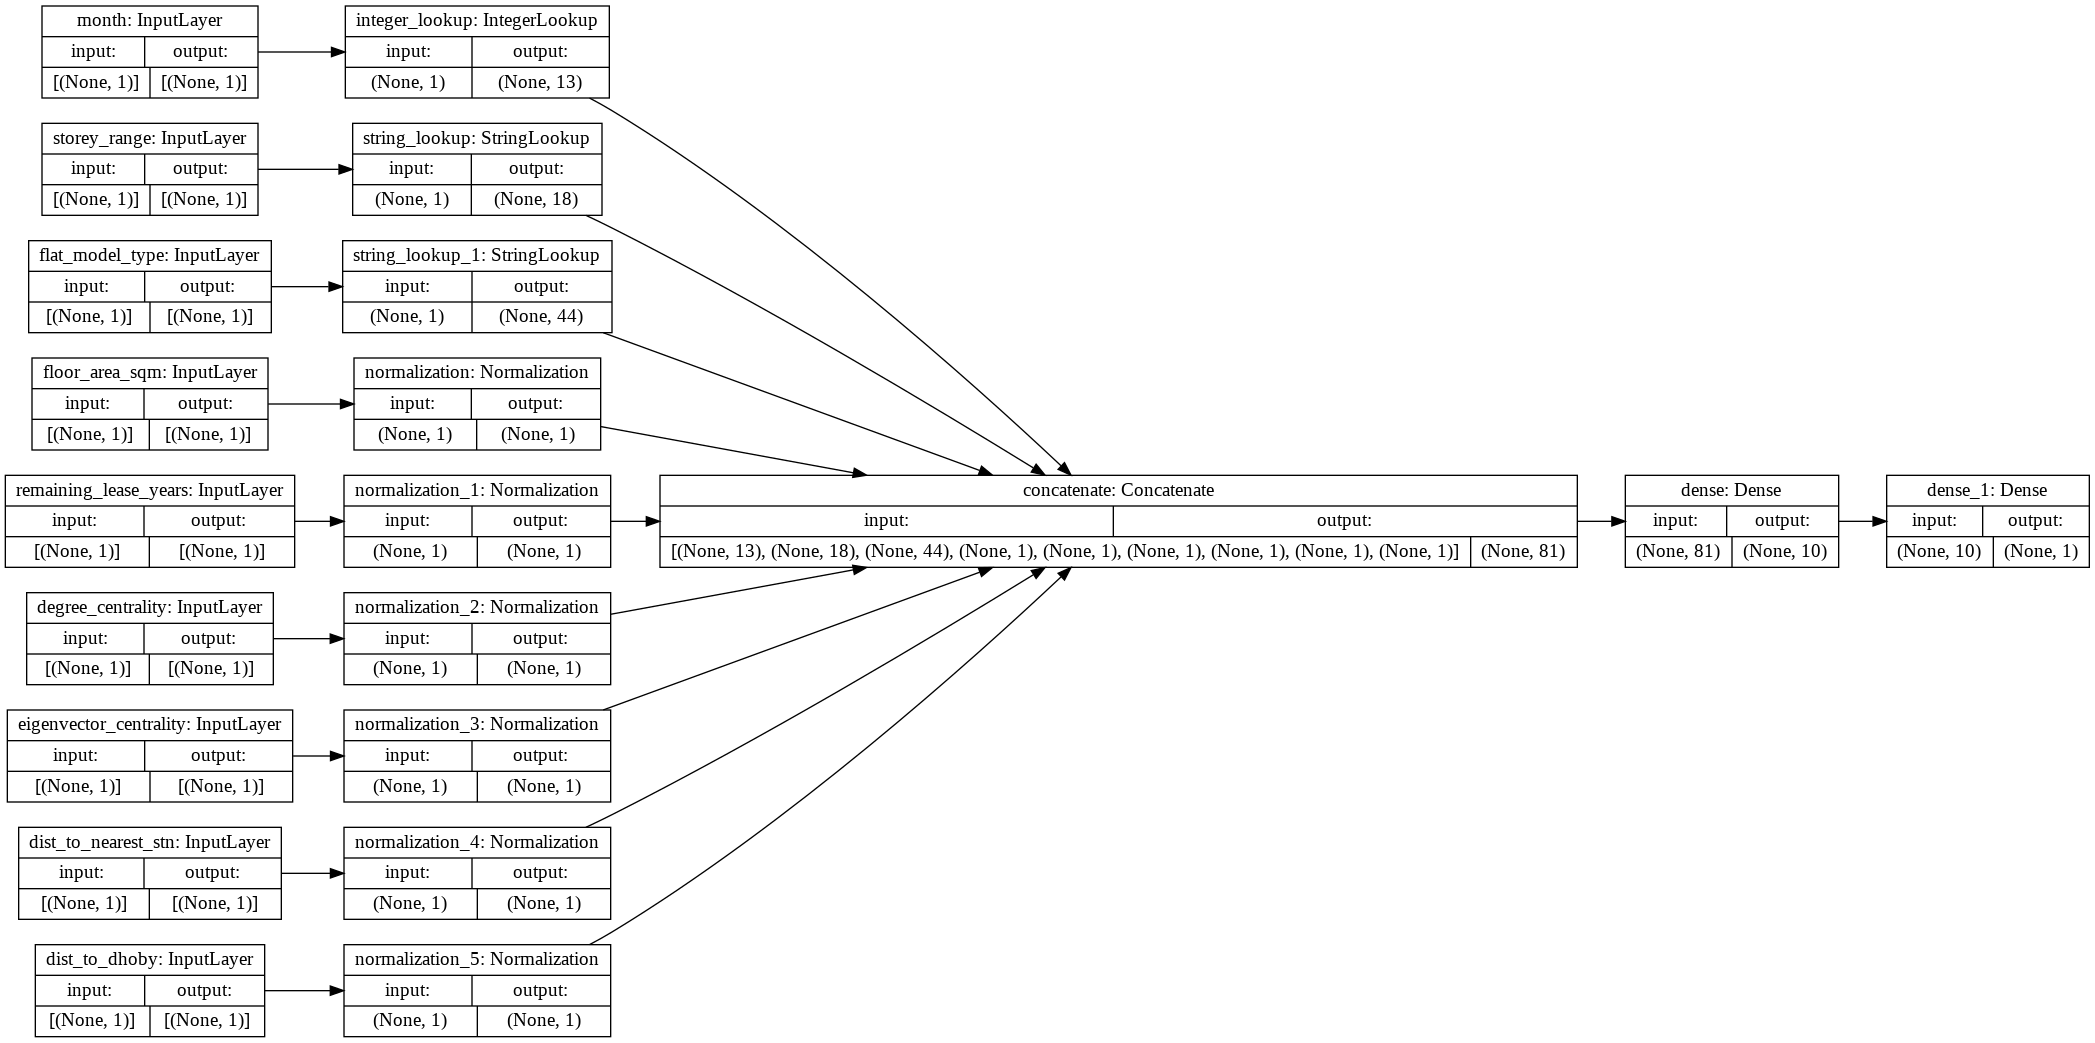

In [7]:
question1 = Question1(train_ds, val_ds)
question1.prepare_model()
question1.create_model()
keras.utils.plot_model(model=question1.model, to_file='p2q1b.png', show_shapes=True, rankdir="LR")

c) On the training data, train the model for 100 epochs using mini-batch gradient descent with batch size = 128, Use ‘adam’ optimiser with a learning rate of alpha = 0.05 and mean square error as cost function. (Tip: Use smaller epochs while you’re still debugging. On Google Colaboratory, 100 epochs take around 10 minutes even without GPU.)

In [8]:
question1.train_model()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_loss improved from inf to 170781016064.00000, saving model to p2q1f.ckpt

Epoch 00002: val_loss improved from 170781016064.00000 to 39842324480.00000, saving model to p2q1f.ckpt

Epoch 00003: val_loss improved from 39842324480.00000 to 10972660736.00000, saving model to p2q1f.ckpt

Epoch 00004: val_loss improved from 10972660736.00000 to 8546634752.00000, saving model to p2q1f.ckpt

Epoch 00005: val_loss improved from 8546634752.00000 to 7963350528.00000, saving model to p2q1f.ckpt

Epoch 00006: val_loss improved from 7963350528.00000 to 7669887488.00000, saving model to p2q1f.ckpt

Epoch 00007: val_loss improved from 7669887488.00000 to 7276782592.00000, saving model to p2q1f.ckpt

Epoch 00008: val_loss improved from 7276782592.00000 to 7104681984.00000, saving model to p2q1f.ckpt

Epoch 00009: val_loss improved from 7104681984.00000 to 6921896448.00000, saving model to p2q1f.ckpt

Epoch 00010: val_loss improved from 6921896448.00000 to 6618027008.00000, saving model

d) Plot the train and test root mean square errors (RMSE) against epochs (Tip: skip the first few epochs, else the plot gets dominated by them).

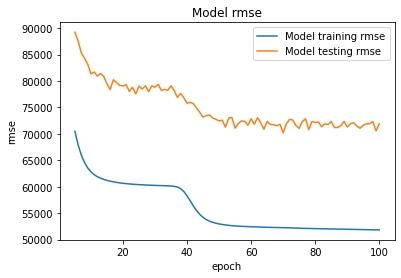

In [9]:
question1.plot_rmse_model(epoch_start=5)

e) State the epoch with the lowest test error. State the test R2 value at that epoch. (Hint: Check the output returned by model.fit(). Use a custom metric for computing R2.)

In [10]:
question1.get_lowest_test_error_model()

Lowest test error: 4928629760.0
Lowest test error epoch: 70
Lowest test error epoch's R2 value: 0.8064669966697693


f) Using the model from that best epoch, plot the predicted values and target values for a batch of 128 test samples. (Hint: Use a callback to restore the best model weights. Find out how to retrieve a batch from tf.BatchDataset. A scatter plot will suffice.)

Before restore best model weights, model has test loss and test r_square as follows:
131/131 [==============================] - 1s 3ms/step - loss: 5170458112.0000 - r_square: 0.7969
After restore best model weights, model has test loss and test r_square as follows:
131/131 [==============================] - 1s 3ms/step - loss: 4928628736.0000 - r_square: 0.8067



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


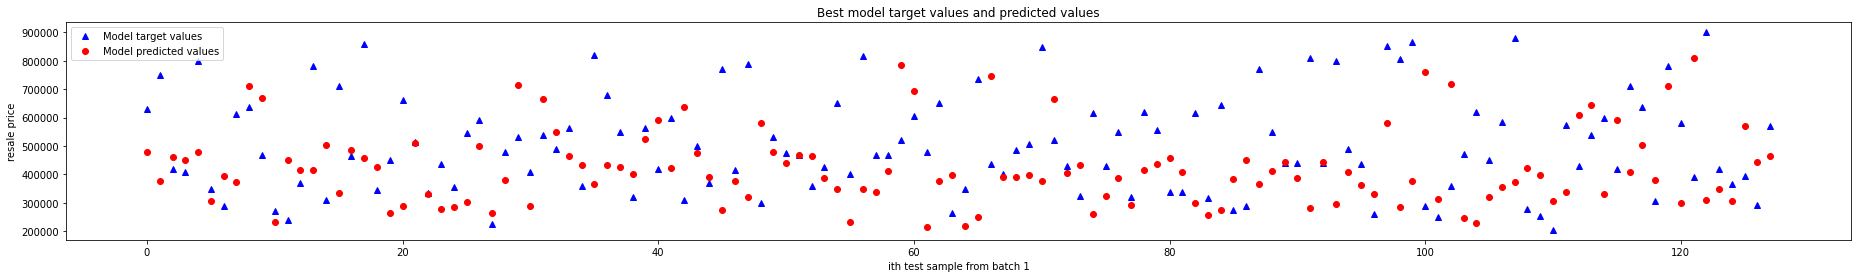

In [11]:
question1.restore_best_model_and_predict()  # test loss and test r_square after restore best model weights

## Question 2

Instead of using one-hot encoding, an alternative approach entails the use of embeddings to encode categorical variables. Such an approach utilises the ability of neural networks to learn richer representations of the data – an edge it has over traditional ML models.

In [18]:
class Question2():

    def __init__(self, train_ds, val_ds, epochs=100):
        self.epochs = epochs
        self.seed = 42
        self.filepath = 'p2q2b.ckpt'
        self.history = None

        self.train_ds = train_ds
        self.val_ds = val_ds

        np.random.seed(self.seed)
        tf.random.set_seed(self.seed)

    def prepare_model(self):
        # integer categorical feature input
        month = keras.Input(shape=(1,), name='month', dtype='int64')

        # string categorical features input
        storey_range = keras.Input(shape=(1,), name='storey_range', dtype='string')
        flat_model_type = keras.Input(shape=(1,), name='flat_model_type', dtype='string')

        # numerical features input
        floor_area_sqm = keras.Input(shape=(1,), name='floor_area_sqm')
        remaining_lease_years = keras.Input(shape=(1,), name='remaining_lease_years')
        degree_centrality = keras.Input(shape=(1,), name='degree_centrality')
        eigenvector_centrality = keras.Input(shape=(1,), name='eigenvector_centrality')
        dist_to_nearest_stn = keras.Input(shape=(1,), name='dist_to_nearest_stn')
        dist_to_dhoby = keras.Input(shape=(1,), name='dist_to_dhoby')

        self.all_inputs = [month,
                           storey_range,
                           flat_model_type,
                           floor_area_sqm,
                           remaining_lease_years,
                           degree_centrality,
                           eigenvector_centrality,
                           dist_to_nearest_stn,
                           dist_to_dhoby]

        # integer categorical feature encoded
        month_encoded = encode_categorical_feature(month, 'month', self.train_ds, False)

        # string categorical features encoded
        storey_range_encoded = encode_categorical_feature(storey_range, 'storey_range', self.train_ds, True)
        flat_model_type_encoded = encode_categorical_feature(flat_model_type, 'flat_model_type', self.train_ds, True)

        # numerical features encoded
        floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, 'floor_area_sqm', self.train_ds)
        remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, 'remaining_lease_years',
                                                                 self.train_ds)
        degree_centrality_encoded = encode_numerical_feature(degree_centrality, 'degree_centrality', self.train_ds)
        eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, 'eigenvector_centrality',
                                                                  self.train_ds)
        dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, 'dist_to_nearest_stn',
                                                               self.train_ds)
        dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, 'dist_to_dhoby', self.train_ds)

        # integer categorical feature embedded and flattened
        month_embedding = tf.keras.layers.Embedding(input_dim=month_encoded.get_shape()[1],
                                                    output_dim=month_encoded.get_shape()[1] // 2)(month_encoded)
        month_embedding_flattened = tf.keras.layers.Flatten()(month_embedding)

        # string categorical features embedded and flattened
        storey_range_embedding = tf.keras.layers.Embedding(input_dim=storey_range_encoded.get_shape()[1],
                                                           output_dim=storey_range_encoded.get_shape()[1] // 2)(
            storey_range_encoded)
        storey_range_embedding_flattened = tf.keras.layers.Flatten()(storey_range_embedding)
        flat_model_type_embedding = tf.keras.layers.Embedding(input_dim=flat_model_type_encoded.get_shape()[1],
                                                              output_dim=flat_model_type_encoded.get_shape()[1] // 2)(
            flat_model_type_encoded)
        flat_model_type_embedding_flattened = tf.keras.layers.Flatten()(flat_model_type_embedding)

        self.all_features = tf.keras.layers.concatenate([month_embedding_flattened,
                                                         storey_range_embedding_flattened,
                                                         flat_model_type_embedding_flattened,
                                                         floor_area_sqm_encoded,
                                                         remaining_lease_years_encoded,
                                                         degree_centrality_encoded,
                                                         eigenvector_centrality_encoded,
                                                         dist_to_nearest_stn_encoded,
                                                         dist_to_dhoby_encoded])

    @staticmethod
    def r_square(y_true, y_pred):
        SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
        SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
        return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

    def create_model(self):
        # create the model
        x = tf.keras.layers.Dense(units=10, activation='relu')(self.all_features)
        output = tf.keras.layers.Dense(units=1, activation='linear')(x)
        self.model = tf.keras.Model(inputs=self.all_inputs, outputs=output)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
                           loss=tf.keras.losses.MeanSquaredError(),
                           metrics=[self.r_square])

    def summarize_model(self):
        # summarize the model
        print(self.model.summary())

    def train_model(self):
        # train the model
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self.filepath,
                                                                       monitor='val_loss',
                                                                       verbose=1,
                                                                       save_best_only=True,
                                                                       save_weights_only=True,
                                                                       mode='min')
        self.history = self.model.fit(x=train_ds,
                                      batch_size=128,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[model_checkpoint_callback],
                                      validation_data=self.val_ds)

    def plot_model(self, variable='loss', epoch_start=1, epoch_end=None):
        # plot learning curves
        train_epochs = self.history.history[variable][epoch_start - 1:epoch_end]
        val_epochs = self.history.history['val_{}'.format(variable)][epoch_start - 1:epoch_end]
        number_epochs = len(self.history.history[variable][epoch_start - 1:epoch_end])

        plt.plot(range(epoch_start, epoch_start + number_epochs), train_epochs,
                 label='Model training {}'.format(variable))
        plt.plot(range(epoch_start, epoch_start + number_epochs), val_epochs, label='Model testing {}'.format(variable))
        plt.title('Model {}'.format(variable))
        plt.ylabel('{}'.format(variable))
        plt.xlabel('epoch')
        plt.legend(loc='best')
        plt.show()

    def plot_rmse_model(self, epoch_start=1, epoch_end=None):
        # plot rmse curves
        train_epochs = list(map(lambda x: math.sqrt(x), self.history.history['loss'][epoch_start - 1:epoch_end]))
        val_epochs = list(map(lambda x: math.sqrt(x), self.history.history['val_loss'][epoch_start - 1:epoch_end]))
        number_epochs = len(self.history.history['loss'][epoch_start - 1:epoch_end])

        plt.plot(range(epoch_start, epoch_start + number_epochs), train_epochs, label='Model training rmse')
        plt.plot(range(epoch_start, epoch_start + number_epochs), val_epochs, label='Model testing rmse')
        plt.title('Model rmse')
        plt.ylabel('rmse')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        plt.show()

    def get_lowest_test_error_model(self):
        # get lowest test error epoch and R2 value
        lowest_test_error, lowest_test_error_epoch = min(
            (value, index + 1) for (index, value) in enumerate(self.history.history['val_loss']))
        print('Lowest test error: {}'.format(lowest_test_error))
        print('Lowest test error epoch: {}'.format(lowest_test_error_epoch))
        print('Lowest test error epoch\'s R2 value: {}'.format(
            self.history.history['val_r_square'][lowest_test_error_epoch - 1]))

    def restore_best_model_and_predict(self):
        # restore weights to model from lowest test error epoch
        print('Before restore best model weights, model has test loss and test r_square as follows:')
        self.model.evaluate(self.val_ds)
        print('After restore best model weights, model has test loss and test r_square as follows:')
        self.model.load_weights(filepath=self.filepath)
        self.model.evaluate(self.val_ds)
        print('')
        target_values = list(self.val_ds.take(1).as_numpy_iterator())[0][1]
        predicted_values = self.model.predict(x=self.val_ds, steps=1)

        # plot targets and predictions
        plt.figure(1, figsize=(32, 4))
        plt.plot(target_values, 'b^', label='Model target values')
        plt.plot(predicted_values, 'ro', label='Model predicted values')
        plt.title('Best model target values and predicted values')
        plt.ylabel('resale price')
        plt.xlabel('ith test sample from batch 1')
        plt.legend(loc='best')
        plt.show()


a) Add an Embedding layer with output_dim = floor(num_categories/2) after the one-hot embeddings for categorical variables. (Hint: Use the tf.keras.layers.Embedding() later. Read the documentation carefully to ensure that you define the correct function parameters.)

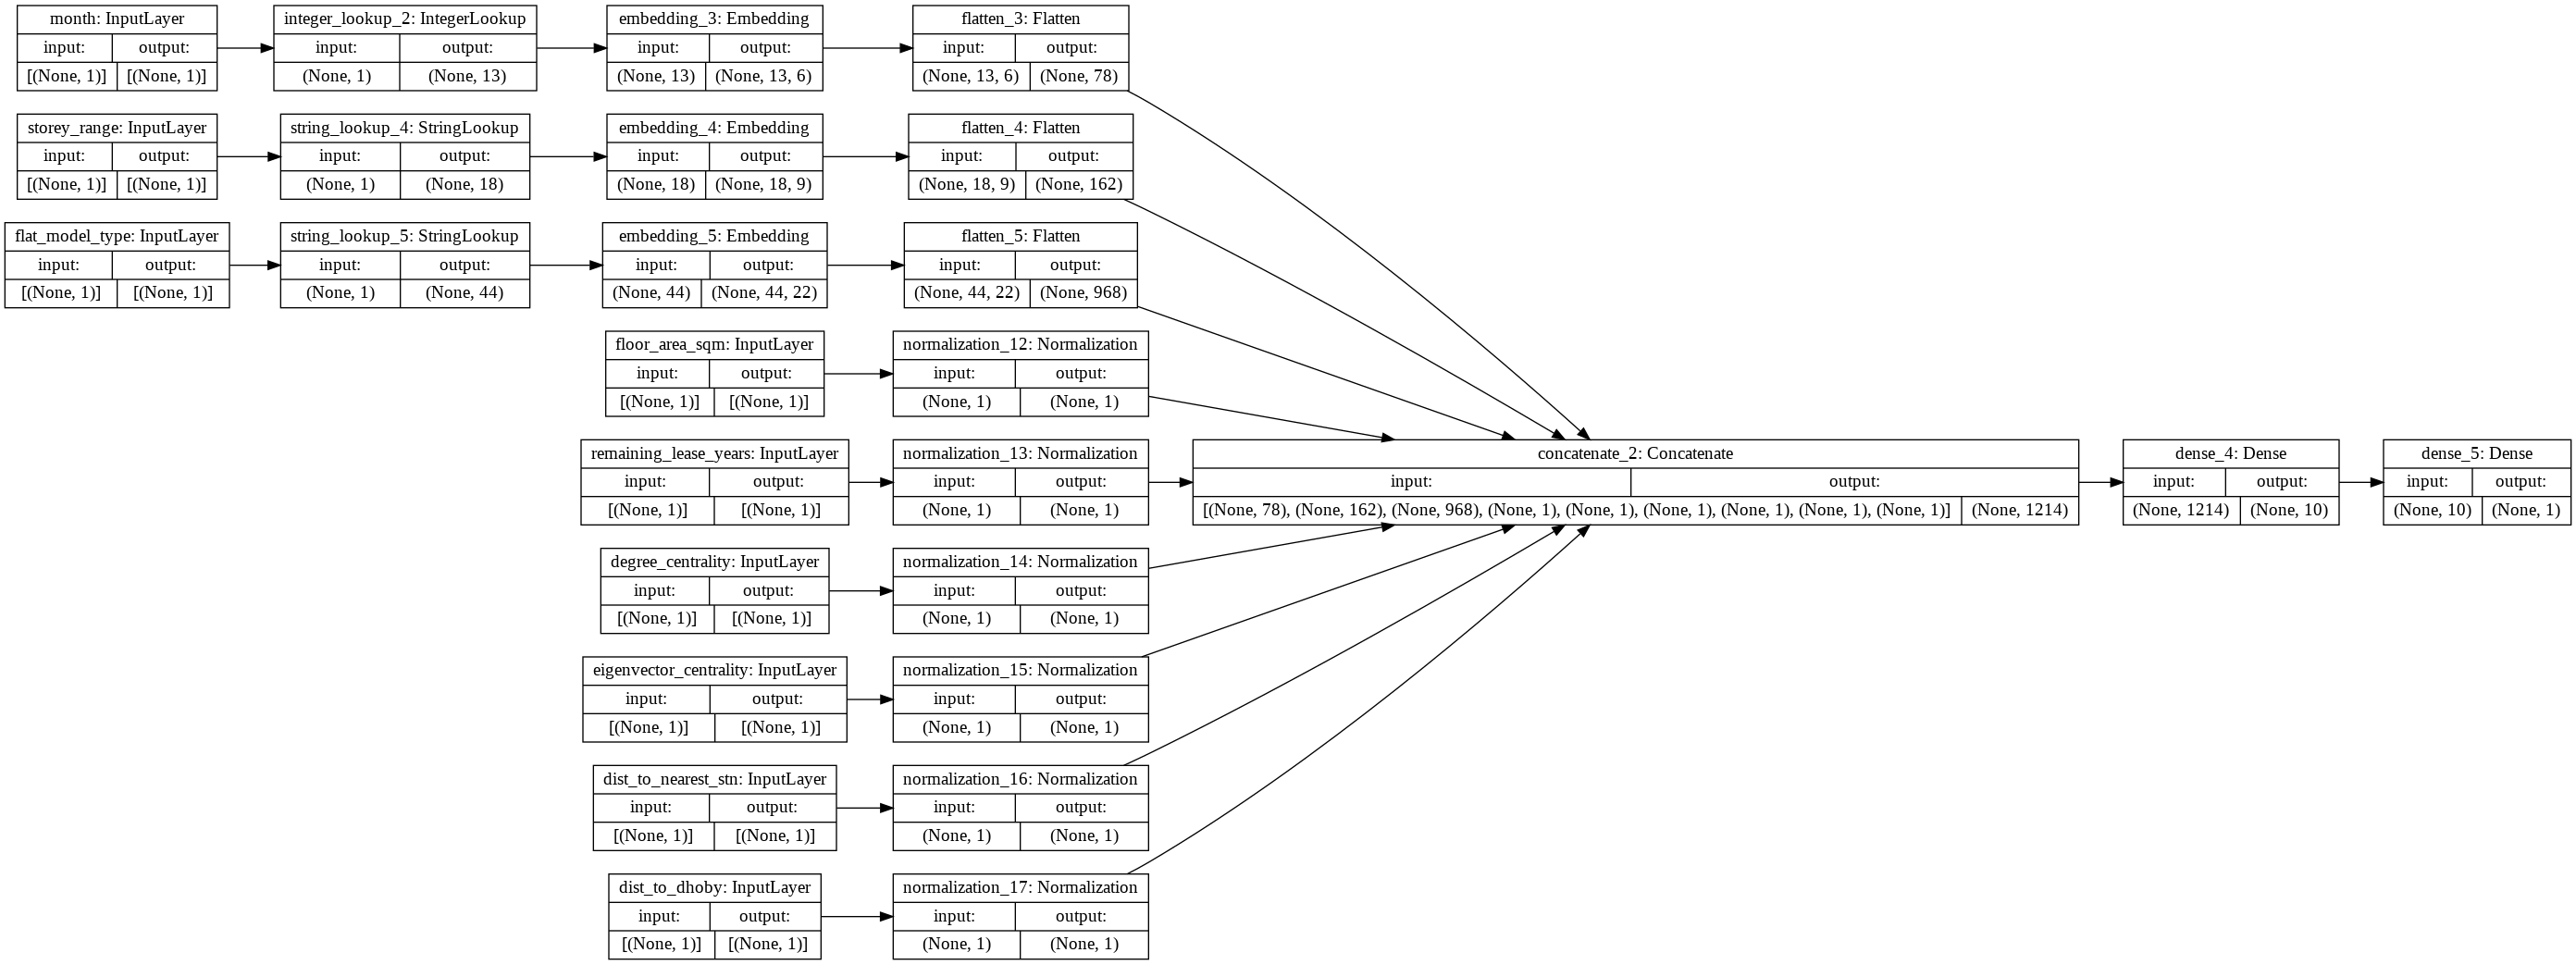

In [19]:
question2 = Question2(train_ds, val_ds)
question2.prepare_model()
question2.create_model()
keras.utils.plot_model(model=question2.model, to_file='p2q2a.png', show_shapes=True, rankdir="LR")

b) The Embedding layer produces a 2D output (3D, including batch), which cannot be concatenated with the other features. Look through the Keras layers API to determine which layer to add in, such that all the features can be concatenated. Train the model using the same configuration as Q1. (Tip: A full run takes ~15 mins, so reduce epochs when debugging your code but remember to switch it back to 100.)

In [20]:
question2.train_model()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_loss improved from inf to 26347403264.00000, saving model to p2q2b.ckpt

Epoch 00002: val_loss improved from 26347403264.00000 to 12534586368.00000, saving model to p2q2b.ckpt

Epoch 00003: val_loss improved from 12534586368.00000 to 10409566208.00000, saving model to p2q2b.ckpt

Epoch 00004: val_loss improved from 10409566208.00000 to 9594167296.00000, saving model to p2q2b.ckpt

Epoch 00005: val_loss improved from 9594167296.00000 to 8521665024.00000, saving model to p2q2b.ckpt

Epoch 00006: val_loss improved from 8521665024.00000 to 7569719296.00000, saving model to p2q2b.ckpt

Epoch 00007: val_loss improved from 7569719296.00000 to 7260656640.00000, saving model to p2q2b.ckpt

Epoch 00008: val_loss did not improve from 7260656640.00000

Epoch 00009: val_loss did not improve from 7260656640.00000

Epoch 00010: val_loss improved from 7260656640.00000 to 6658330112.00000, saving model to p2q2b.ckpt

Epoch 00011: val_loss improved from 6658330112.00000 to 5403721216.0

c) Compare the current model performances in terms of both test RMSE and test R2 with the model from Q1 (at their own best epochs) and suggest a possible reason for the difference in performance. 

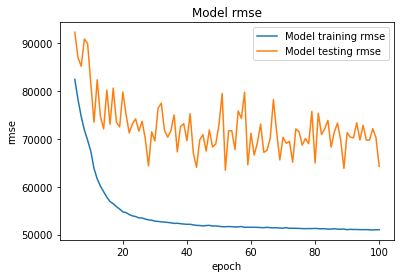

In [21]:
question2.plot_rmse_model(epoch_start=5)

In [22]:
question2.get_lowest_test_error_model()

Lowest test error: 4026497792.0
Lowest test error epoch: 52
Lowest test error epoch's R2 value: 0.8422166109085083


Before restore best model weights, model has test loss and test r_square as follows:
131/131 [==============================] - 1s 4ms/step - loss: 4131841024.0000 - r_square: 0.8378
After restore best model weights, model has test loss and test r_square as follows:
131/131 [==============================] - 1s 5ms/step - loss: 4026498560.0000 - r_square: 0.8419



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


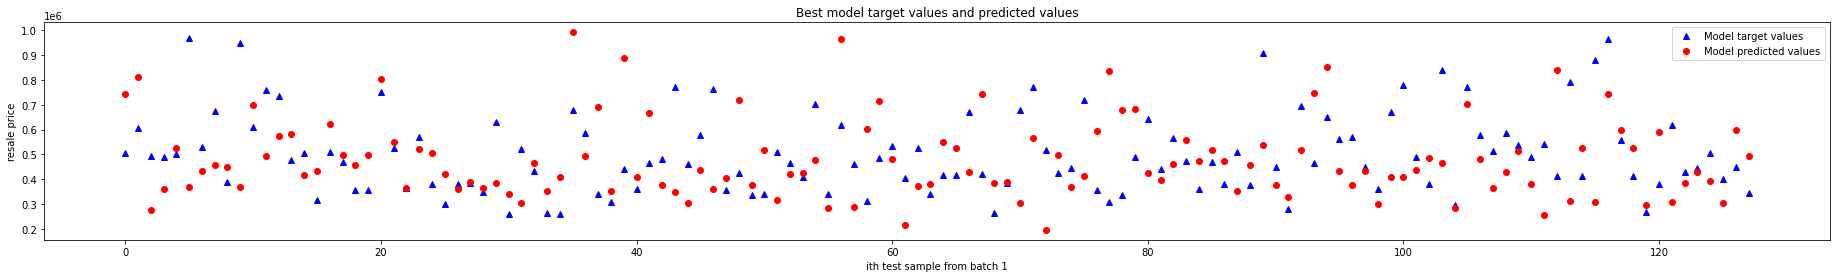

In [23]:
question2.restore_best_model_and_predict()  # test loss and test r_square after restore best model weights